PHYS 514 -- Final Project -- Tevfik Can Yüce, 64065

In [179]:
import numpy as np
import newton_functions
import matplotlib.pyplot as plt
import pandas as pd
import scipy.constants as constants
import scipy.stats
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy.interpolate import CubicSpline
from scipy.optimize import minimize
from scipy.optimize import curve_fit

Newton Part

Part (b):

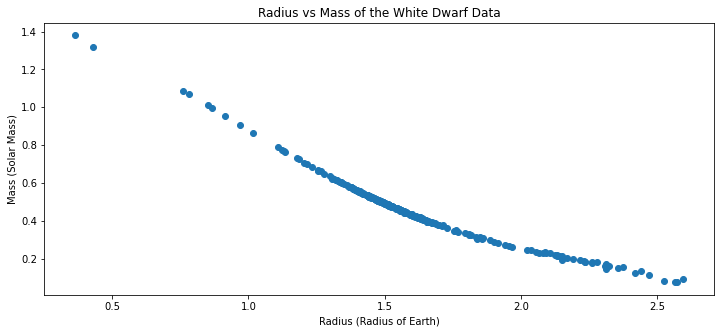

In [2]:
#Reading of the data file in .csv format
filename = 'white_dwarf_data.csv'

#Reading file in format of DataFrame
data_frame = pd.read_csv(filename)

#Convert mass and surface gravity to numpy array
logg_arr = data_frame.loc[:,"logg"].to_numpy()
mass_arr = data_frame.loc[:,"mass"].to_numpy()

#Converting Log Gravity to Radius
solar_mass = 1.98847e30
earth_radius = 6.3781e6
earth_gravity = 9.807
earth_gravity = 1
radius_arr = np.sqrt((constants.gravitational_constant * (mass_arr * solar_mass)) / (0.01 * np.power(earth_radius, 2) * np.power(10, logg_arr)))

#Plotting the Data
plt.figure(figsize=(12,5))
plt.scatter(x=radius_arr, y=mass_arr)
plt.xlabel('Radius (Radius of Earth)')
plt.ylabel('Mass (Solar Mass)')
plt.title('Radius vs Mass of the White Dwarf Data')
plt.show()

#Scaling of mass and radius to SI units
radius_arr = earth_radius * radius_arr
mass_arr = solar_mass * mass_arr


Part (c):

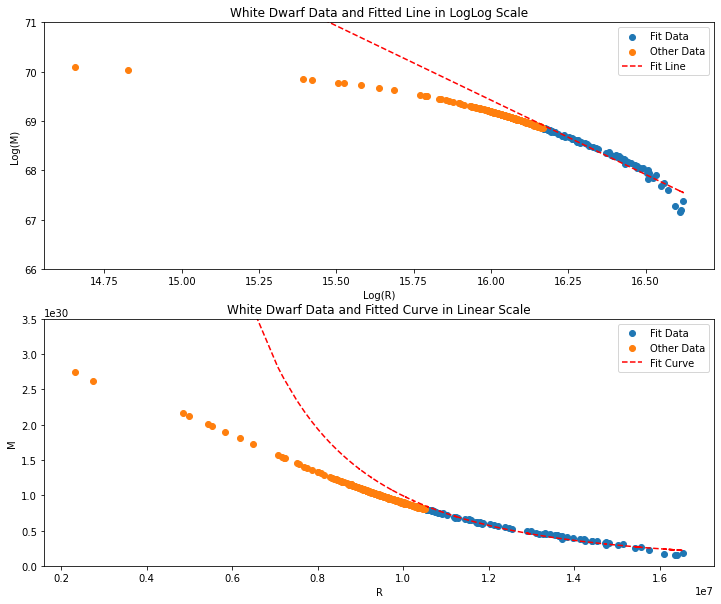

Fitted value of slope is -3.0082493216686275


In [212]:
#Parameters
N = 80 #Smallest N stars are considered as low mass

#First sort the arrays w.r.t to mass
#Sorting the arrray
sort_idx = np.argsort(mass_arr)
radius_arr = radius_arr[sort_idx]
mass_arr = mass_arr[sort_idx]

#Fitting Line to Data in Log-Log Scale
regressed_line = scipy.stats.linregress(x=np.log(radius_arr[0:N]), y=np.log(mass_arr[0:N]))

#Plotting Data
fig, ax = plt.subplots(nrows=2, ncols=1)
fig.set_size_inches(12,10)

#Plotting in Log Scale
ax[0].scatter(np.log(radius_arr[0:N]), np.log(mass_arr[0:N]))
ax[0].scatter(np.log(radius_arr[N:]), np.log(mass_arr[N:]))
ax[0].plot(np.log(radius_arr), regressed_line.slope * np.log(radius_arr) + regressed_line.intercept, '--', color='red')
ax[0].legend(['Fit Data', 'Other Data', 'Fit Line'])
ax[0].set_ylim([66, 71])
ax[0].set_xlabel('Log(R)')
ax[0].set_ylabel('Log(M)')
ax[0].set_title('White Dwarf Data and Fitted Line in LogLog Scale')

#Plotting in Linear Scale
ax[1].scatter(radius_arr[0:N], mass_arr[0:N])
ax[1].scatter(radius_arr[N:], mass_arr[N:])
ax[1].plot(radius_arr, np.exp(regressed_line.intercept)*np.power(radius_arr, regressed_line.slope), '--', color='red')
ax[1].legend(['Fit Data', 'Other Data', 'Fit Curve'])
ax[1].set_ylim([0, 0.35e31])
ax[1].set_title('White Dwarf Data and Fitted Curve in Linear Scale')
ax[1].set_xlabel('R')
ax[1].set_ylabel('M')

plt.show()

#Printing Results
print('Fitted value of slope is ' + str(regressed_line.slope))

d:\ELEC COURSES\PHYS514\Final Project\newton_functions.py:19: RuntimeWarning: invalid value encountered in power
  f[1] = -np.power(y[0], n) - (2/t) * y[1]


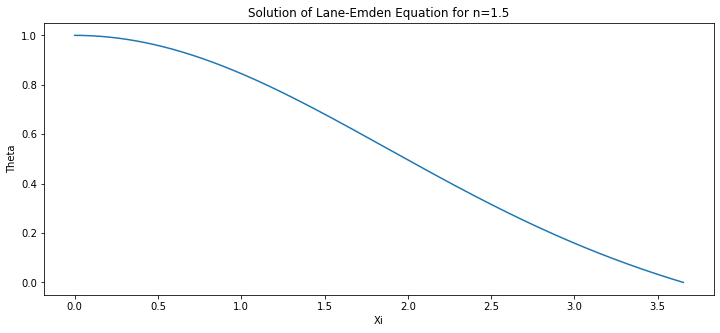

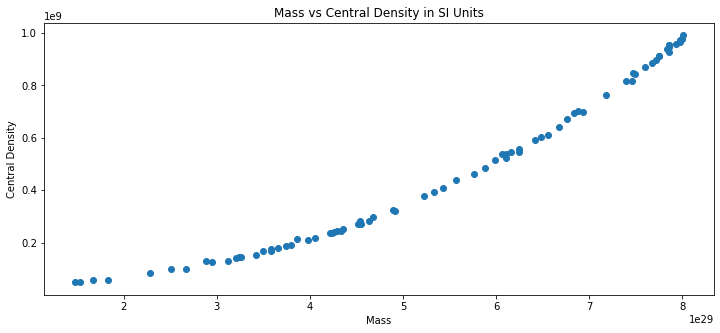

xi_n = 3.6537537362191084
theta prime at xi_n = -0.20330128263854969
K = 2949576.7909595263


In [213]:
#This cell calculates K_star and central density

#Finding xi_n, theta_prime at xi_n
n_star = 1.5 #Found and set from knowledge of previous part
xi, theta, theta_prime = newton_functions.lane_emden_solve(n=n_star, xi_f=20)

#Plotting Solution of Lane-Emden Equation
plt.figure(figsize=(12,5))
plt.plot(xi, theta)
plt.xlabel('Xi')
plt.ylabel('Theta')
plt.title('Solution of Lane-Emden Equation for n=1.5')
plt.show()

#Needed values
xi_n = xi[-1]
theta_prime_xi_n = theta_prime[-1]

#Calculate K_star
K_star = (4*np.pi*constants.gravitational_constant/2.5) * np.power(np.exp(regressed_line.intercept)/(-4*np.pi*np.power(xi_n, 5)*theta_prime_xi_n), 1/3)

#Calculate central density
rho_c_arr_low_mass = (mass_arr[0:N]/(4*np.pi*np.power(radius_arr[0:N],3))) * (- xi_n/theta_prime_xi_n)

#Plotting the Data
plt.figure(figsize=(12,5))
plt.scatter(x=mass_arr[0:N], y=rho_c_arr_low_mass)
plt.xlabel('Mass')
plt.ylabel('Central Density')
plt.title('Mass vs Central Density in SI Units')
plt.show()

#Print calculated values
print('xi_n = ' +str(xi_n))
print('theta prime at xi_n = ' + str(theta_prime_xi_n))
print('K = ' + str(K_star))


Part (d):

In [214]:
#Parameters
q = 3

#First getting initial rho_c value
rho_c_initial = (mass_arr[0]/(4*np.pi*np.power(radius_arr[0], 3))) * (-xi_n/theta_prime_xi_n)

print(rho_c_initial)

#Now have an initial guess of D
small_x = 1e-4
D_initial = rho_c_initial / np.power(small_x, 3)
print(D_initial)
print(np.power(rho_c_initial/D_initial, 1/3))

#Parameters of IVP Solution
D = D_initial
C = (5 * K_star * np.power(D, 5/q)) / 8

#IVP Solution for these values
def f_rhs(t, y):
    rhs = np.zeros(len(y)) #Initialize RHS to zero

    x = np.power(y[1]/D, 1/q) #Calculate x
    df_dx = (8*C*np.power(x, 4))/(np.sqrt(np.power(x,2) + 1)) #Calculate dP/dx


    rhs[0] = 4*np.pi*np.power(t, 2) * y[1]
    if t == 0:
        rhs[1] = 0
    else:
        rhs[1] = (1/df_dx)*q*D*np.power(y[1]/D, -(1/q)+1) * (-constants.gravitational_constant*y[0]*y[1]/np.power(t, 2))
    
    return rhs

#Initial vector
y0 = np.asarray([0, rho_c_initial]).astype(float)

solution = solve_ivp(fun=f_rhs, y0=y0, t_span=(0,2e7), method='RK45', max_step = 1e4)

48128832.06683346
4.812883206683345e+19
0.00010000000000000006


C:\Users\teyfik can\AppData\Local\Temp\ipykernel_3556\2247375868.py:23: RuntimeWarning: invalid value encountered in power
  x = np.power(y[1]/D, 1/q) #Calculate x
C:\Users\teyfik can\AppData\Local\Temp\ipykernel_3556\2247375868.py:31: RuntimeWarning: invalid value encountered in power
  rhs[1] = (1/df_dx)*q*D*np.power(y[1]/D, -(1/q)+1) * (-constants.gravitational_constant*y[0]*y[1]/np.power(t, 2))


In [215]:
#Define the function that calculates (R,M) pair for given rho_c and D
def calculate_R_M(rho_c, D):
    #Parameters
    q = 3
    C = (5 * K_star * np.power(D, 5/q)) / 8
    max_step = 1e5

    #Function to be used in IVP solution (RHS of mass-density ODE)
    def f_rhs(t, y):
        rhs = np.zeros(len(y)) #Initialize RHS to zero

        x = np.power(y[1]/D, 1/q) #Calculate x
        df_dx = (8*C*np.power(x, 4))/(np.sqrt(np.power(x,2) + 1)) #Calculate dP/dx


        rhs[0] = 4*np.pi*np.power(t, 2) * y[1]
        if t == 0:
            rhs[1] = 0
        else:
            rhs[1] = (1/df_dx)*q*D*np.power(y[1]/D, -(1/q)+1) * (-constants.gravitational_constant*y[0]*y[1]/np.power(t, 2))
        
        return rhs

    #Initial value vector of IVP
    y0 = np.asarray([0, rho_c]).astype(float)

    #Solution of IVP
    solution = solve_ivp(fun=f_rhs, y0=y0, t_span=(0,3e7), method='RK45')
    
    #Return R-M pair
    return solution.t[-1], solution.y[0,-1]
    

In [216]:
#This function prepares R-M data to proper format for cubic spline fitting
def prepare_for_spline(radius_arr, mass_arr):
    sorted_r, indices_r = np.unique(radius_arr, return_index=True)

    radius_arr_new = np.zeros(len(indices_r))
    mass_arr_new = np.zeros(len(indices_r))

    for i in range(len(indices_r)-1):
        if indices_r[i]<=indices_r[i+1]:
            avg_element = np.mean(mass_arr[indices_r[i]:indices_r[i+1]])
        else:
            avg_element = np.mean(mass_arr[indices_r[i+1]:indices_r[i]])

        mass_arr_new[i] = avg_element
        radius_arr_new[i] = radius_arr[indices_r[i]]
    
    #Final element
    mass_arr_new[-1] = mass_arr[indices_r[-1]]
    radius_arr_new[-1] = radius_arr[indices_r[-1]]

    return radius_arr_new, mass_arr_new

In [217]:
#This function calculates the error for given spline function and value of D and central denisty array
def calculate_err_D(spline_func, rho_c_vals, D):
    #Calculate R-M pairs for given central density vals
    R_vals = []
    M_vals = []
    for rho_c in rho_c_vals:
        R,M = calculate_R_M(rho_c=rho_c, D=D)
        R_vals.append(R)
        M_vals.append(M)
    
    return np.sqrt(np.mean(np.power(spline_func(R_vals) - M_vals, 2))) / solar_mass
    #return np.mean(np.sqrt(np.abs( np.power(spline_func(R_vals), 2) - np.power(M_vals, 2) ))) / solar_mass

In [218]:
#This function finds appropriate min and max central density values for given D
def find_central_density_limits(D, rho_c_initial, n_search_samples, min_R, max_R):
    #Broad range of central density values
    rho_c_vals = rho_c_initial * np.logspace(0.15, 10, n_search_samples)

    #Finding R values of rho_c values
    R_vals = []
    for rho_c in rho_c_vals:
        R,M = calculate_R_M(rho_c, D)
        R_vals.append(R)

    R_vals = np.asarray(R_vals).astype(float) #Convert to numpy array

    rho_c_min_idx = np.abs(R_vals - min_R).argmin() #İndex of closest element to min R
    rho_c_max_idx = np.abs(R_vals - max_R).argmin() #İndex of closest element to max R

    return rho_c_vals[rho_c_min_idx], rho_c_vals[rho_c_max_idx]


48128832.06683346


C:\Users\teyfik can\AppData\Local\Temp\ipykernel_3556\3166944924.py:12: RuntimeWarning: invalid value encountered in power
  x = np.power(y[1]/D, 1/q) #Calculate x
C:\Users\teyfik can\AppData\Local\Temp\ipykernel_3556\3166944924.py:20: RuntimeWarning: invalid value encountered in power
  rhs[1] = (1/df_dx)*q*D*np.power(y[1]/D, -(1/q)+1) * (-constants.gravitational_constant*y[0]*y[1]/np.power(t, 2))


ln(D) = [45.32041309]  Err = 2.6881053985277954
ln(D) = [45.32041308]  Err = 2.688105398527485
ln(D) = [45.32038205]  Err = 2.688105397577027
ln(D) = [45.32038206]  Err = 2.688105397577315
ln(D) = [45.31998763]  Err = 2.688105385477475
ln(D) = [45.31998764]  Err = 2.6881053854777868
ln(D) = [45.31840998]  Err = 2.6881053370482344
ln(D) = [45.31840999]  Err = 2.6881053370485493
ln(D) = [45.31209936]  Err = 2.688105142825298
ln(D) = [45.31209937]  Err = 2.688105142825609
ln(D) = [45.28685687]  Err = 2.6881043577109067
ln(D) = [45.28685688]  Err = 2.6881043577112216
ln(D) = [45.18588692]  Err = 2.68810108174359
ln(D) = [45.18588693]  Err = 2.688101081743931
ln(D) = [44.7820071]  Err = 2.6880855325332993
ln(D) = [44.78200711]  Err = 2.6880855325337447
ln(D) = [43.16648785]  Err = 2.687958021207616
ln(D) = [43.16648786]  Err = 2.6879580212089174
ln(D) = [36.70441082]  Err = 2.673905086734056
ln(D) = [36.70441083]  Err = 2.6739050868280096
ln(D) = [10.85610274]  Err = 0.4891560540581042
ln(D

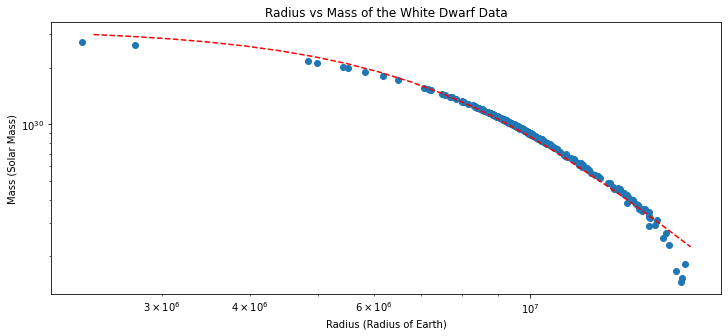

In [219]:
#Parameters
N_samples = 20

#Now investigate how to change rho_c in order to cover all radius range
rho_c_initial = (mass_arr[0]/(4*np.pi*np.power(radius_arr[0], 3))) * (-xi_n/theta_prime_xi_n)

print(rho_c_initial)

#Now have an initial guess of D
small_x = 1e-4
D_initial = rho_c_initial / np.power(small_x, 3)

def fun_minimize_D(ln_D):
    D = np.exp(ln_D)
    rho_c_min, rho_c_max = find_central_density_limits(D=D, rho_c_initial=rho_c_initial, n_search_samples=10, min_R=np.min(radius_arr), max_R=np.max(radius_arr))
    rho_c_vals = np.logspace(np.log10(rho_c_min), np.log10(rho_c_max), N_samples)
    #err = calculate_err_D(spline_func=spline, rho_c_vals=rho_c_vals, D=np.exp(ln_D))
    #Calculate R-M pairs for given central density vals
    R_vals = []
    M_vals = []
    for rho_c in rho_c_vals:
        R,M = calculate_R_M(rho_c=rho_c, D=D)
        R_vals.append(R)
        M_vals.append(M)

    R_vals = np.asarray(R_vals).astype(float)
    M_vals = np.asarray(M_vals).astype(float)
    
    #Fitting Spline to calculated values
    spline = CubicSpline(x=R_vals, y=M_vals)

    #Calculate Error
    err = np.sqrt( np.mean(np.power(mass_arr - spline(radius_arr), 2)) ) / solar_mass

    print('ln(D) = ' + str(ln_D) + '  Err = ' + str(err))

    return err

#result = minimize(fun=fun_minimize_D, x0=[D_initial/100], method='Nelder-Mead', options={'disp': True}, bounds=[(1,D_initial)])
result = minimize(fun=fun_minimize_D, x0=[np.log(D_initial)], options={'disp':True, 'ftol':1e-12}, bounds=[(10,np.log(D_initial))])
print(result.success)

R_vals = []
M_vals = []
rho_c_min, rho_c_max = find_central_density_limits(D=np.exp(result.x), rho_c_initial=rho_c_initial, n_search_samples=50, min_R=np.min(radius_arr), max_R=np.max(radius_arr))
rho_c_vals = np.logspace(np.log10(rho_c_min), np.log10(rho_c_max), N_samples)
for rho_c in rho_c_vals:
    R,M = calculate_R_M(rho_c=rho_c, D=np.exp(result.x))
    R_vals.append(R)
    M_vals.append(M)

print(calculate_err_D(spline_func=spline, rho_c_vals=rho_c_vals, D=np.exp(result.x)))


#Plotting low mass original data
plt.figure(figsize=(12,5))
plt.scatter(x=radius_arr, y=mass_arr)
#plt.scatter(x=R_vals, y=M_vals)
plt.plot(R_vals, M_vals, '--', color='red')
#plt.scatter(x=radius_arr_spline, y=mass_arr_spline)
#plt.plot(R_vals, spline(R_vals), '--', color='red')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Radius (Radius of Earth)')
plt.ylabel('Mass (Solar Mass)')
plt.title('Radius vs Mass of the White Dwarf Data')
plt.show()

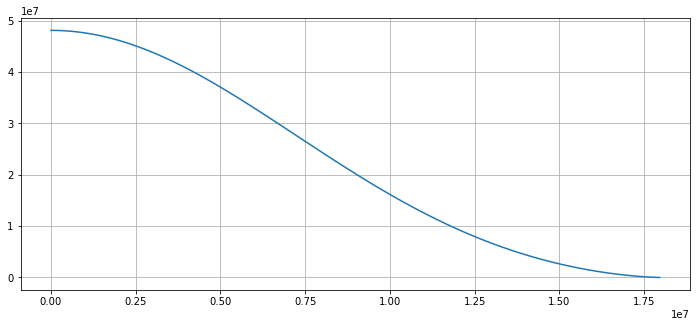

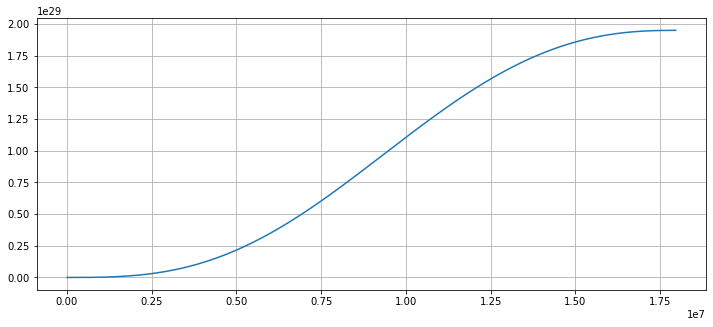

1859
1.098505438409554e-05


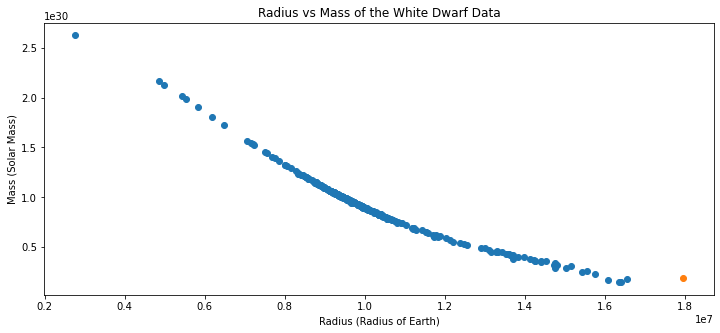

48128832.06683346
4.812883206683345e+19
Radius = 17963065.54661662
Mass = 1.950551312881709e+29


In [15]:
N_plt = -1
plt.figure(figsize=(12,5))
plt.plot(solution.t, solution.y[1,:])
plt.grid(True)
plt.show()

plt.figure(figsize=(12,5))
plt.plot(solution.t, solution.y[0,:])
plt.grid(True)
plt.show()

print(len(solution.t))
print(solution.t[-1]/(1e5*radius_arr[0]))


#Plotting low mass original data
plt.figure(figsize=(12,5))
plt.scatter(x=radius_arr[0:-1], y=mass_arr[0:-1])
plt.scatter(x=solution.t[-1], y=solution.y[0,-1])
plt.xlabel('Radius (Radius of Earth)')
plt.ylabel('Mass (Solar Mass)')
plt.title('Radius vs Mass of the White Dwarf Data')
plt.show()

print(rho_c_arr_low_mass[0])
print(D)

print('Radius = ' + str(solution.t[-1]))
print('Mass = ' + str(solution.y[0,-1]))

1.1305733132990002e+51
5.990704516303412
10271139.054516703


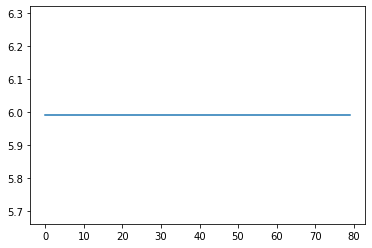

In [45]:
#Test of the calculated rho_c values
rho_avg = (3 * mass_arr[0:N])/(4*np.pi*np.power(radius_arr[0:N], 3))

#Take ratio
plt.plot(rho_c_arr_low_mass/rho_avg)

print(np.exp(regressed_line.intercept))
print(np.mean(rho_c_arr_low_mass/rho_avg))

print(radius_arr[100])

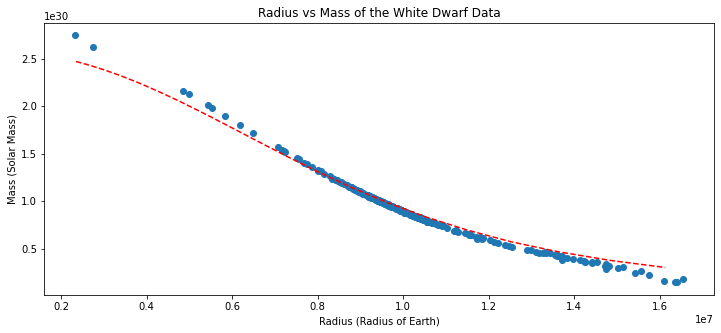

In [172]:
plt.figure(figsize=(12,5))
plt.scatter(x=radius_arr, y=mass_arr)
plt.plot(R_vals, M_vals, '--', color='red')
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Radius (Radius of Earth)')
plt.ylabel('Mass (Solar Mass)')
plt.title('Radius vs Mass of the White Dwarf Data')
plt.show()

4.812883206683345e+19
[21.17911333]
[1.57750974e+09]


C:\Users\teyfik can\AppData\Local\Temp\ipykernel_3556\3166944924.py:12: RuntimeWarning: invalid value encountered in power
  x = np.power(y[1]/D, 1/q) #Calculate x
C:\Users\teyfik can\AppData\Local\Temp\ipykernel_3556\3166944924.py:20: RuntimeWarning: invalid value encountered in power
  rhs[1] = (1/df_dx)*q*D*np.power(y[1]/D, -(1/q)+1) * (-constants.gravitational_constant*y[0]*y[1]/np.power(t, 2))


ln(D) = [21.17911333]  Err = 3.8936186784227153e+28
3.8936186784227153e+28
ln(D) = 21.3899999614  Err = 6.432167095169386e+28
6.432167095169386e+28


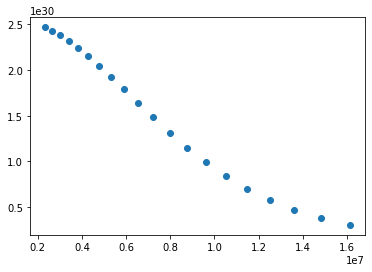

In [169]:
print(D_initial)
print(result.x)
print(np.exp(result.x))
print(fun_minimize_D(result.x))
print(fun_minimize_D(21.3899999614))
plt.scatter(R_vals, M_vals)